In [1]:
# Import all modules
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from keras import backend as K
import torch.nn as nn
import pickle
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")
import matplotlib.colors as mcolors
from PIL import Image
import scipy
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import h5py
import torch.utils.data
# Import Tensorflow with multiprocessing
import multiprocessing as mp

import os
import cv2

data_dir = '../data/'
output_dir = '../output/'

/home/joonsikk/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_AwA():
    train_input = np.squeeze(np.load(data_dir + 'train_input.npy'))
    train_label = np.squeeze(np.load(data_dir + 'train_label.npy'))
    val_input = np.squeeze(np.load(data_dir + 'val_input.npy'))
    val_label = np.squeeze(np.load(data_dir + 'val_label.npy'))
    train_feature = np.squeeze(np.load(data_dir + 'train_feature_awa.npy'))
    train_output = np.squeeze(np.load(data_dir + 'train_output_awa.npy'))
    val_feature = np.squeeze(np.load(data_dir + 'val_feature_awa.npy'))
    val_output = np.squeeze(np.load(data_dir + 'val_output_awa.npy'))
    return train_input,train_label,val_input,val_label,train_feature,train_output,val_feature,val_output

def resnet50_model(file):
    model = models.__dict__['resnet50'](pretrained = True)
    model.fc = torch.nn.Linear(2048,50)
    model = torch.nn.DataParallel(model).cuda()
    # optionally resume from a checkpoint
    print("=> loading checkpoint '{}'".format(file))
    checkpoint = torch.load(file)
    best_prec1 = checkpoint['best_prec1']
    model.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (epoch {})"
                  .format(file, checkpoint['epoch'])) 
    feature_model = nn.Sequential(*list(model.module.children())[:-1])
    feature_model = torch.nn.DataParallel(feature_model)
    feature_model = feature_model.cuda()
    return model,feature_model

# Declare variables
num_classes = 50 #    
target_class = 9

model,feature_model = resnet50_model(data_dir + 'checkpoint.pth.tar')
train_input,train_label,val_input,val_label,train_feature,train_output,val_feature,val_output = load_AwA() 
x_train = train_input
y_train = train_label
x_test = val_input
y_test = val_label

train_output34 = train_feature
test_output34 = val_feature

class_names = dict()
class_names[0] = 'antelope' 
class_names[1] = 'bat'
class_names[2] = 'beaver'
class_names[3] = 'blue whale' 
class_names[4] = 'bobcat'
class_names[5] = 'buffalo' 
class_names[6] = 'chihuahua' 
class_names[7] = 'chimpanzee'
class_names[8] = 'collie' 
class_names[9] = 'cow'
class_names[10] = 'dalmation' 
class_names[11] = 'deer'
class_names[12] = 'dolphin'
class_names[13] = 'elephant' 
class_names[14] = 'fox'
class_names[15] = 'german shepherd' 
class_names[16] = 'giant panda' 
class_names[17] = 'giraffe'
class_names[18] = 'gorilla' 
class_names[19] = 'grizzly bear'
class_names[20] = 'hamster' 
class_names[21] = 'hippopotamus'
class_names[22] = 'horse'
class_names[23] = 'humpback whale' 
class_names[24] = 'killer whale'
class_names[25] = 'leopard' 
class_names[26] = 'lion' 
class_names[27] = 'mole'
class_names[28] = 'moose' 
class_names[29] = 'mouse'
class_names[30] = 'otter' 
class_names[31] = 'ox'
class_names[32] = 'persian cat'
class_names[33] = 'pig' 
class_names[34] = 'polar bear'
class_names[35] = 'rabbit' 
class_names[36] = 'raccoon' 
class_names[37] = 'rat'
class_names[38] = 'rhinoceros' 
class_names[39] = 'seal'
class_names[40] = 'sheep' 
class_names[41] = 'siamese cat'
class_names[42] = 'skunk'
class_names[43] = 'spider monkey' 
class_names[44] = 'squirrel'
class_names[45] = 'tiger' 
class_names[46] = 'walrus' 
class_names[47] = 'weasel'
class_names[48] = 'wolf' 
class_names[49] = 'zebra'

output_test_labels = np.argmax(val_output,axis=1)
output_train_labels = np.argmax(train_output,axis=1)

# Extra functions for visualization
def denormalize(image,mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225]):
    return image*expand_dims_3(std) + expand_dims_3(mean)

def expand_dims_3(arr):
    return np.expand_dims(np.expand_dims(arr,0),0)

# Functions for rescaling the images
def normalize2rgb(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

def norm(img):
    return np.linalg.norm(img, axis=0)

def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

mycmap = transparent_cmap(plt.cm.plasma)


=> loading checkpoint 'data/checkpoint.pth.tar'
=> loaded checkpoint 'data/checkpoint.pth.tar' (epoch 90)


In [3]:
# sort the weight matrix for each target class
weight_matrix = np.load(output_dir + 'weight_matrix_AwA.npz')['weight_matrix']

top_orders = dict()
for k in range(num_classes):
    idx = np.flip(np.argsort(weight_matrix[:,k]), axis=0)
    top_orders[k] = idx
    
top_abs_orders = dict()
for k in range(num_classes):
    idx = np.flip(np.argsort(np.abs(weight_matrix[:,k])), axis=0)
    top_abs_orders[k] = idx

In [4]:
def compute_dot_grads_on_test(model,feature_model,train_input,train_label,val_input,val_label,train_feature,train_output,val_feature,val_output, img_rows, img_cols, channel=3, idx=[], test_point=None, eps_array= 0):
    # Compute gradients of the feature products w.r.t. to the test points
    top_k = 5
    grads_all = []
    for i in idx:
        X = Variable(torch.from_numpy(np.expand_dims(val_input[test_point,:],axis=0)+eps_array).cuda(),requires_grad = True)
        feature_test = torch.squeeze(feature_model(X)) 
        p1 = feature_test*(Variable(torch.from_numpy(train_feature[i,:]).cuda(),requires_grad = False)).unsqueeze(0)
        top_p1 = torch.topk(p1,top_k,1)[0]
        product = torch.sum(top_p1)
        feature_model.zero_grad()
        product.backward()
        eval_grads = X.grad 
        grads_all.append(eval_grads.data.cpu().numpy())
    return grads_all

def compute_dot_grads_on_train(model,feature_model,train_input,train_label,val_input,val_label,train_feature,train_output,val_feature,val_output, img_rows, img_cols, channel=3, idx=[], test_point=None, eps_array= 0):
    # Compute gradients of the feature products w.r.t. to the train points
    top_k = 5
    grads_all = []
    for i in idx:
        X = Variable(torch.from_numpy(np.expand_dims(train_input[i,:],axis=0)+eps_array).cuda(),requires_grad = True)
        feature_train = torch.squeeze(feature_model(X)) 
        p1 = feature_train*(Variable(torch.from_numpy(val_feature[test_point,:]).cuda(),requires_grad = False)).unsqueeze(0)
        top_p1 = torch.topk(p1,top_k,1)[0]
        product = torch.sum(top_p1)
        feature_model.zero_grad()
        product.backward()
        eval_grads = X.grad 
        grads_all.append(eval_grads.data.cpu().numpy())
    return grads_all

def compute_test_grad(model,feature_model,train_input,train_label,val_input,val_label,train_feature,train_output,val_feature,val_output, img_rows, img_cols, channel=3, test_point=None,eps_array = 0):
    # Compute gradients of the test output w.r.t. to the test points
    model.zero_grad()  
    X = Variable(torch.from_numpy(np.expand_dims(val_input[test_point,:],axis=0)+eps_array).cuda(),requires_grad = True)
    test = model(X)[:,val_label[test_point]]
    test = torch.sum(test)
    test.backward()
    eval_grads = X.grad 
    return eval_grads.data.cpu().numpy()

def compute_train_grad(model,feature_model,train_input,train_label,val_input,val_label,train_feature,train_output,val_feature,val_output, img_rows, img_cols, channel=3, train_point=None,eps_array = 0):
    # Compute gradients w.r.t. to the training point
    model.zero_grad()  
    X = Variable(torch.from_numpy(np.expand_dims(train_input[train_point,:],axis=0)+eps_array).cuda(),requires_grad = True)
    train = model(X)[:,train_label[train_point]]
    train = torch.sum(train)
    train.backward()
    eval_grads = X.grad 
    return eval_grads.data.cpu().numpy()

def expand_dims_3(arr):
    return np.expand_dims(np.expand_dims(arr,0),0)

def denormalize(image,mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225]):
    return image*expand_dims_3(std) + expand_dims_3(mean)

def sample_eps(image,epsilon,N):
    # sampling function for Smoothgrad
    images = np.tile(image,(N,1,1,1))
    dim = images.shape
    norm = np.random.normal
    normal_deviates = np.reshape(norm(size=(dim)),(N,-1))
    total_dim = normal_deviates.shape[1]
    radius = np.linalg.norm(normal_deviates,axis = 1, keepdims=True)
    normal_deviates = normal_deviates * (np.random.rand(N,total_dim)**(1.0/total_dim))
    points = np.reshape(normal_deviates*(epsilon)/radius,dim)
    return points.astype(np.float32)

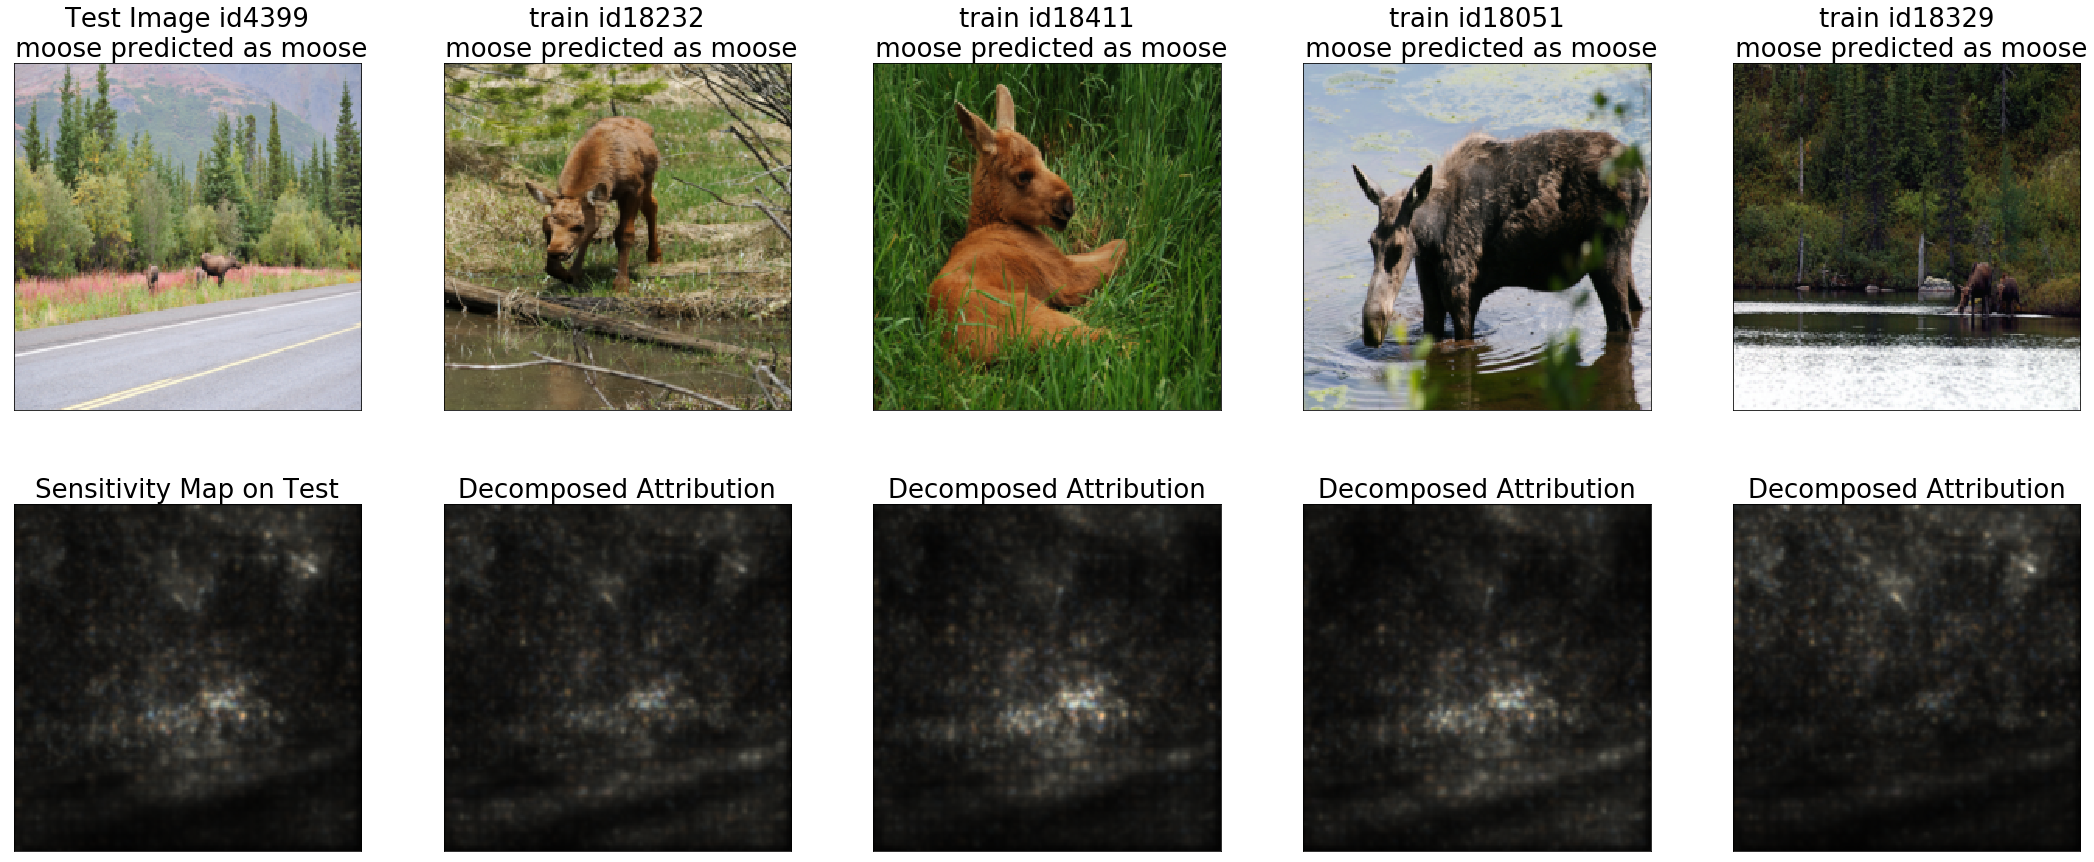

In [142]:
model.eval()
feature_model.eval()
# Define the test points to analyze
test_points = [7400, 4399]

import matplotlib as mpl
for test_point in test_points:
    mpl.rcParams["figure.figsize"]=15,15
    target_class = y_test[test_point]
    
    # Sort by alpha * train * test values, not just the weight
    tmp = weight_matrix[:, target_class] * np.sum(train_feature * val_feature[test_point,:], axis=1)
    idx = np.flip(np.argsort(tmp), axis=0)

    
    # select top k 
    k = 4
    k_range = idx[:k]
    epsilon = 30.0
    eps_array = sample_eps(x_test[0], epsilon,100)
    
    g_noise_sigma = 1.0
    
    dot_grads_test = compute_dot_grads_on_test(model,feature_model,train_input,train_label,val_input,val_label,train_feature,train_output,val_feature,val_output, 224, 224, channel=3, idx=k_range, test_point=test_point,eps_array= eps_array)
    test_grad = compute_test_grad(model,feature_model,train_input,train_label,val_input,val_label,train_feature,train_output,val_feature,val_output, 224, 224, channel=3, test_point=test_point,eps_array = eps_array)
    
    f, ax = plt.subplots(2, k+1, figsize=(30,13))
    count = 0
        
    image = denormalize(x_test[test_point,:].transpose(1,2,0))

    saliency = norm(test_grad)
    saliency = saliency/(np.sum(saliency))*224*224/3
    saliency = scipy.ndimage.filters.gaussian_filter(saliency, g_noise_sigma)
    
    # show the test image and the test point sensitivity map
    ax[0,count].imshow(image)
    ax[0,count].set_title('Test Image id%d\n %s predicted as %s'\
                          %(test_point, class_names[y_test[test_point]], class_names[output_test_labels[test_point]]), 
                         fontsize=26)
    ax[1,count].imshow(saliency.transpose(1,2,0))
    ax[1,count].set_title('Sensitivity Map on Test', fontsize=26)
    ax[0,count].set_xticks(())
    ax[0,count].set_yticks(())
    ax[1,count].set_xticks(())
    ax[1,count].set_yticks(())

    for i in k_range:
        # show training images on the first column
        ax[0, count+1].imshow(denormalize(x_train[i].transpose(1,2,0)))
        ax[0, count+1].set_title('train id%d\n %s predicted as %s'%(i, class_names[y_train[i]], class_names[output_train_labels[i]]), fontsize=26)
        ax[0, count+1].set_xticks(())
        ax[0, count+1].set_yticks(())

        # gradient decomposed
        dot_sal_test = norm(dot_grads_test[count] - test_grad)
        dot_sal_test = dot_sal_test/(np.sum(dot_sal_test))*224*224/3
        dot_sal_test = scipy.ndimage.filters.gaussian_filter(dot_sal_test, g_noise_sigma)
        ax[1, count+1].imshow(dot_sal_test.transpose(1,2,0))
        ax[1, count+1].set_title('Decomposed Attribution', fontsize=26)
        ax[1, count+1].set_xticks(())
        ax[1, count+1].set_yticks(())
        count += 1
    plt.tight_layout()